<a href="https://colab.research.google.com/github/mervegb/collaborative-filtering/blob/main/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [32]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [33]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieIds: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users,2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieIds: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


<ipython-input-34-1574b7711e73>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


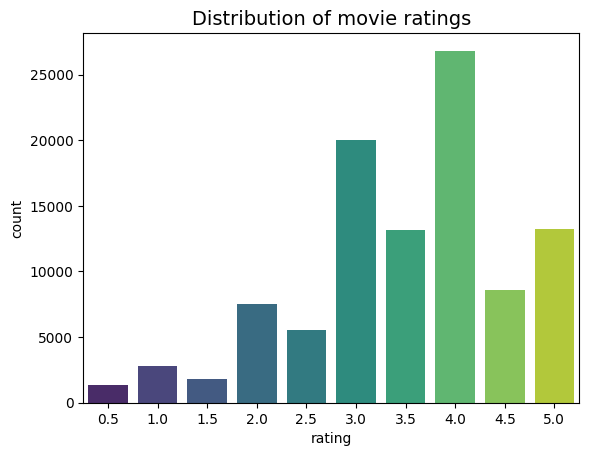

In [34]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [35]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [36]:
#movies most frequently rated
movie_ratings = ratings.merge(movies,on="movieId") #merges ratings & movies based on movieId column
movie_ratings["title"].value_counts()[0:10] #value_counts() method counts the occurences of each unique value in the title column

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


In [37]:
#which movie has the lowest and highest average rating
mean_ratings = ratings.groupby("movieId")[["rating"]].mean()

lowest_rated = mean_ratings["rating"].idxmin()
movies[movies['movieId']==lowest_rated] #return the movie with the lowest average rating

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [38]:
highest_rated = mean_ratings["rating"].idxmax()
movies[movies["movieId"] == highest_rated] #return the movie with the highest average rating

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamarica may be the highest rated movie but it only has 2 ratings. Better approach for evaluating movie popularity is to look at Bayesian average.

#Bayesian Average
Provide more reliable rakings by adressing potential biases in the raw average.

For example, a movie with only few ratings might have a high raw average but using Bayesian average gives more weight to prior knowledge.

In [39]:
#for each movie, calculate how many times that movie has been rated & average rating each movie has received
movie_stats = ratings.groupby("movieId")["rating"].agg(["count", "mean"])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [40]:
C = movie_stats["count"].mean()
m = movie_stats["mean"].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [41]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

3.543

In [42]:
#apply bayesian avg to all movies in our dataset
bayesian_avg_ratings = ratings.groupby("movieId")["rating"].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ["movieId", "bayesian_avg"]
movie_stats = movie_stats.merge(bayesian_avg_ratings, on="movieId")

In [43]:
movie_stats = movie_stats.merge(movies[["movieId", "title"]])
movie_stats.sort_values("bayesian_avg", ascending=False).head()

#Using the bayesian avg, these are the most highly rated movies

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [44]:
#movie datasets needs to be cleaned in 2 ways: genres & title

movies['genres'] = movies['genres'].apply(lambda x: x.split("|") if isinstance(x, str) else x)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [45]:
#how many movie genres are there
from collections import Counter #to count the occurences of objects


#iterate over each list of genres in the movies["genres"] column, flatten those lists into individual genres, count how many times each genre appears using Counter
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
genre_frequency

Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [46]:
print("The most common movie genres are:\n", genre_frequency.most_common(5))

The most common movie genres are:
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


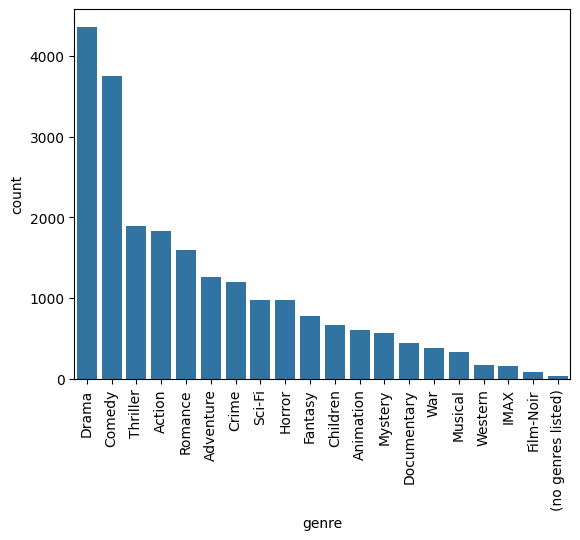

In [49]:
#visualize genres popularity with a bar plot
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ["genre", "count"]

sns.barplot(x="genre", y="count", data=genre_frequency_df.sort_values(by="count", ascending=False))
plt.xticks(rotation=90)
plt.show()

In [50]:
#First step is to transform our data into a user-item matrix
#In this matrix, rows represents users and columns represent movies
#user_mapper => maps user id to user index
#movie_mapper => maps movie id to movie index
#user_inv_mapper => maps user index to user id
#movie_inv_mapper => maps movie index to movie id

# Inverse mappings are useful if you want to look up to the original user or movie id from a matrix index

from scipy.sparse import csr_matrix


def create_X(df):
  """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

  M = df['userId'].nunique() #number of unique users
  N = df['movieId'].nunique() #number of unique movies

  #mapper is a dictionary that helps us translate real-world IDs into continuous row and column indices
  #user_mapper maps user IDs to row numbers in the matrix
  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))

  #movie_mapper maps movie IDs to column numbers in the matrix
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N)))) #movie_mapper = {10: 0, 20: 1, 30: 2}

  #inverse of user_mapper, maps row index back to the original userId
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))

  #inverse of movie_mapper, maps column index back to the original movieId
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"]))) #movie_inv_mapper = {0: 10, 1: 20, 2: 30}


  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]

  X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))

  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [52]:
X.shape #our X matrix contains 610 users and 9724 movies

(610, 9724)